In [92]:
import pandas as pd

column_names = ['datetime', 'pH']  
ph_dataset = pd.read_csv('cyano_culture_datasets/04-25-2025 culture/ph_log_2025-04-25_12-45-58.csv', header=None, names=column_names)
ph_dataset['unixtime'] = pd.to_datetime(ph_dataset['datetime']).astype('int64') // 10**9

In [93]:
column_names = ['datetime', 'dO'] 
do_dataset_1 = pd.read_csv('cyano_culture_datasets/04-25-2025 culture/do_log_2025-04-25_12-46-01.csv', header=None, names=column_names)
do_dataset_1['unixtime'] = pd.to_datetime(do_dataset_1['datetime']).astype('int64') // 10**9

do_dataset_2 = pd.read_csv('cyano_culture_datasets/04-25-2025 culture/do_log_2025-05-01_15-28-03.csv', header=None, names=column_names)
do_dataset_2['unixtime'] = pd.to_datetime(do_dataset_2['datetime']).astype('int64') // 10**9

merged = pd.merge(do_dataset_1, do_dataset_2, on='unixtime', how='outer', suffixes=('_1', '_2'))
merged['datetime'] = merged['datetime_1'].combine_first(merged['datetime_2'])
merged['Dissolved Oxygen (mg/L)'] = merged['dO_1'].combine_first(merged['dO_2'])
merged_do_dataset = merged[['unixtime', 'datetime', 'Dissolved Oxygen (mg/L)']]

In [94]:
column_names = ['datetime', 'Temperature (C)']
temp_dataset = pd.read_csv('cyano_culture_datasets/04-25-2025 culture/temperature_log_2025-04-25_12-45-52.csv', header=None, names=column_names)
temp_dataset['unixtime'] = pd.to_datetime(temp_dataset['datetime']).astype('int64') // 10**9

In [95]:
column_names = ['datetime', 'red_intensity', 'blue_intensity', 'green_intensity', 'color_combined']  
color_dataset = pd.read_csv('cyano_culture_datasets/04-25-2025 culture/color_log_2025-04-25_12-45-43.txt', header=None, names=column_names)
color_dataset['unixtime'] = pd.to_datetime(color_dataset['datetime']).astype('int64') // 10**9

In [96]:
df_combined = pd.merge(
    merged_do_dataset, ph_dataset, on="unixtime", how="outer", suffixes=("_do", "_ph")
)
df_combined = pd.merge(df_combined, temp_dataset, on="unixtime", how="outer")
df_combined = pd.merge(df_combined, color_dataset, on="unixtime", how="outer")

df_combined = df_combined.sort_values(by="unixtime").reset_index(drop=True)
df_combined["datetime"] = (
    df_combined["datetime_do"]
    .combine_first(df_combined["datetime_ph"])
    .combine_first(df_combined["datetime_x"])
    .combine_first(df_combined["datetime_y"])
)

df_combined = df_combined.drop(
    columns=["datetime_do", "datetime_ph", "datetime_x", "datetime_y"]
)
desired_order = [
    'unixtime', 'datetime', 'Temperature (C)', 'pH', 'Dissolved Oxygen (mg/L)',
    'red_intensity', 'green_intensity', 'blue_intensity', 'color_combined'
]

df_combined = df_combined[desired_order]

In [97]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_combined['Dissolved Oxygen (mg/L)'].quantile(0.25)
Q3 = df_combined['Dissolved Oxygen (mg/L)'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define acceptable range for the data (going for 2.5*IQR below Q1 and above Q3)
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

original_len = len(df_combined) 
# Filter the dataframe to remove outliers in "Dissolved Oxygen"
df_combined = df_combined[
    (df_combined['Dissolved Oxygen (mg/L)'] >= lower_bound) & 
    (df_combined['Dissolved Oxygen (mg/L)'] <= upper_bound)
].copy()

print(f"Removed {original_len - len(df_combined)} outliers from 'Dissolved Oxygen'.")


Removed 452 outliers from 'Dissolved Oxygen'.


In [98]:
# # ADDING A FILTER FOR THE TIME RANGE
# start_time = 1744741273  # Replace with your start time in Unix time
# end_time = 1745406765  # Replace with your end time in Unix time
# df_combined = df_combined[
#     (df_combined["unixtime"] >= start_time) & (df_combined["unixtime"] <= end_time)
# ]

In [99]:
# Convert the datetime column to actual datetime objects
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Function to calculate light intensity
def get_light_intensity(dt):
    dt = pd.to_datetime(dt)
    hour = dt.hour
    return 150 if 8 <= hour < 20 else 0

# Apply function to create new column
df_combined['Light Intensity (μmol photons m² s⁻¹)'] = df_combined['datetime'].apply(get_light_intensity)
df_combined


,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen (mg/L),red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹)
10,1745585163,2025-04-25 12:46:03.708937,27.89,7.017,6.87,NaN,NaN,NaN,NaN,150
11,1745585164,2025-04-25 12:46:04.028266,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150
12,1745585164,2025-04-25 12:46:04.030379,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150
13,1745585164,2025-04-25 12:46:04.034474,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150
14,1745585165,2025-04-25 12:46:05.023055,27.88,7.016,6.87,NaN,NaN,NaN,NaN,150
...,...,...,...,...,...,...,...,...,...,...
544954,1746113332,2025-05-01 15:28:52.045289,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150
544955,1746113333,2025-05-01 15:28:53.032330,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150
544956,1746113334,2025-05-01 15:28:54.017664,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150
544957,1746113335,2025-05-01 15:28:55.004149,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150


In [100]:
# df_combined = df_combined[: -1480] # take off the final bit where the dissolved Oxygne spikes

In [101]:
df_combined.to_csv(
    'cyano_culture_datasets/04-25-2025 culture/combined_dataset.csv',
    index=False
)

In [102]:
import numpy as np
I_0 = df_combined['red_intensity'].max()
def calculate_od_from_red_intensity(red_intensity, I0 = I_0):
    if pd.isna(red_intensity):
        return np.nan
    # Replace with your actual formula. For example:
    if red_intensity <= 0: return np.nan
    return -np.log10(red_intensity / I0)

df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)
df_combined



,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen (mg/L),red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹),Optical Density (620 nm - 750 nm)
10,1745585163,2025-04-25 12:46:03.708937,27.89,7.017,6.87,NaN,NaN,NaN,NaN,150,NaN
11,1745585164,2025-04-25 12:46:04.028266,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150,NaN
12,1745585164,2025-04-25 12:46:04.030379,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150,NaN
13,1745585164,2025-04-25 12:46:04.034474,27.89,7.016,6.87,NaN,NaN,NaN,NaN,150,NaN
14,1745585165,2025-04-25 12:46:05.023055,27.88,7.016,6.87,NaN,NaN,NaN,NaN,150,NaN
...,...,...,...,...,...,...,...,...,...,...,...
544954,1746113332,2025-05-01 15:28:52.045289,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150,NaN
544955,1746113333,2025-05-01 15:28:53.032330,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150,NaN
544956,1746113334,2025-05-01 15:28:54.017664,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150,NaN
544957,1746113335,2025-05-01 15:28:55.004149,NaN,NaN,5.74,NaN,NaN,NaN,NaN,150,NaN


# What's the data look like?

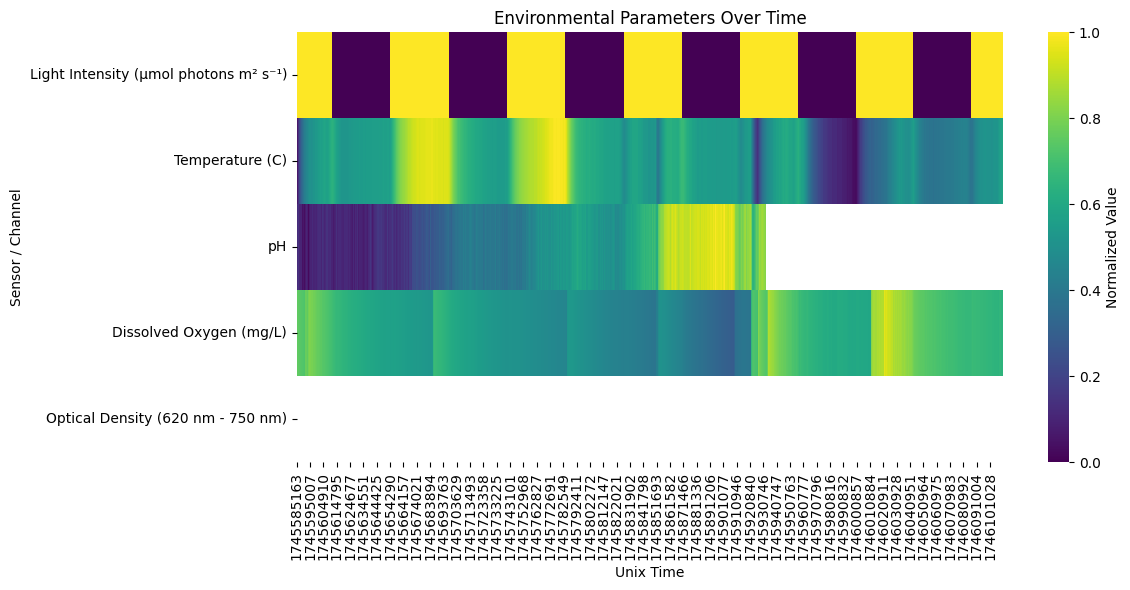

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen (mg/L)",
        "Optical Density (620 nm - 750 nm)",
    ]
]
heatmap_data = heatmap_data.dropna(how="all")
heatmap_data = heatmap_data.set_index("unixtime")
normalized = (heatmap_data - heatmap_data.min()) / (
    heatmap_data.max() - heatmap_data.min()
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized.transpose(), cmap="viridis", cbar_kws={"label": "Normalized Value"}
)
plt.xlabel("Unix Time")
plt.ylabel("Sensor / Channel")
plt.title("Environmental Parameters Over Time")
plt.tight_layout()
plt.show()

/var/folders/w8/skrhf2l569j8bp_zxp38dpn40000gn/T/ipykernel_32391/2964679650.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=18)


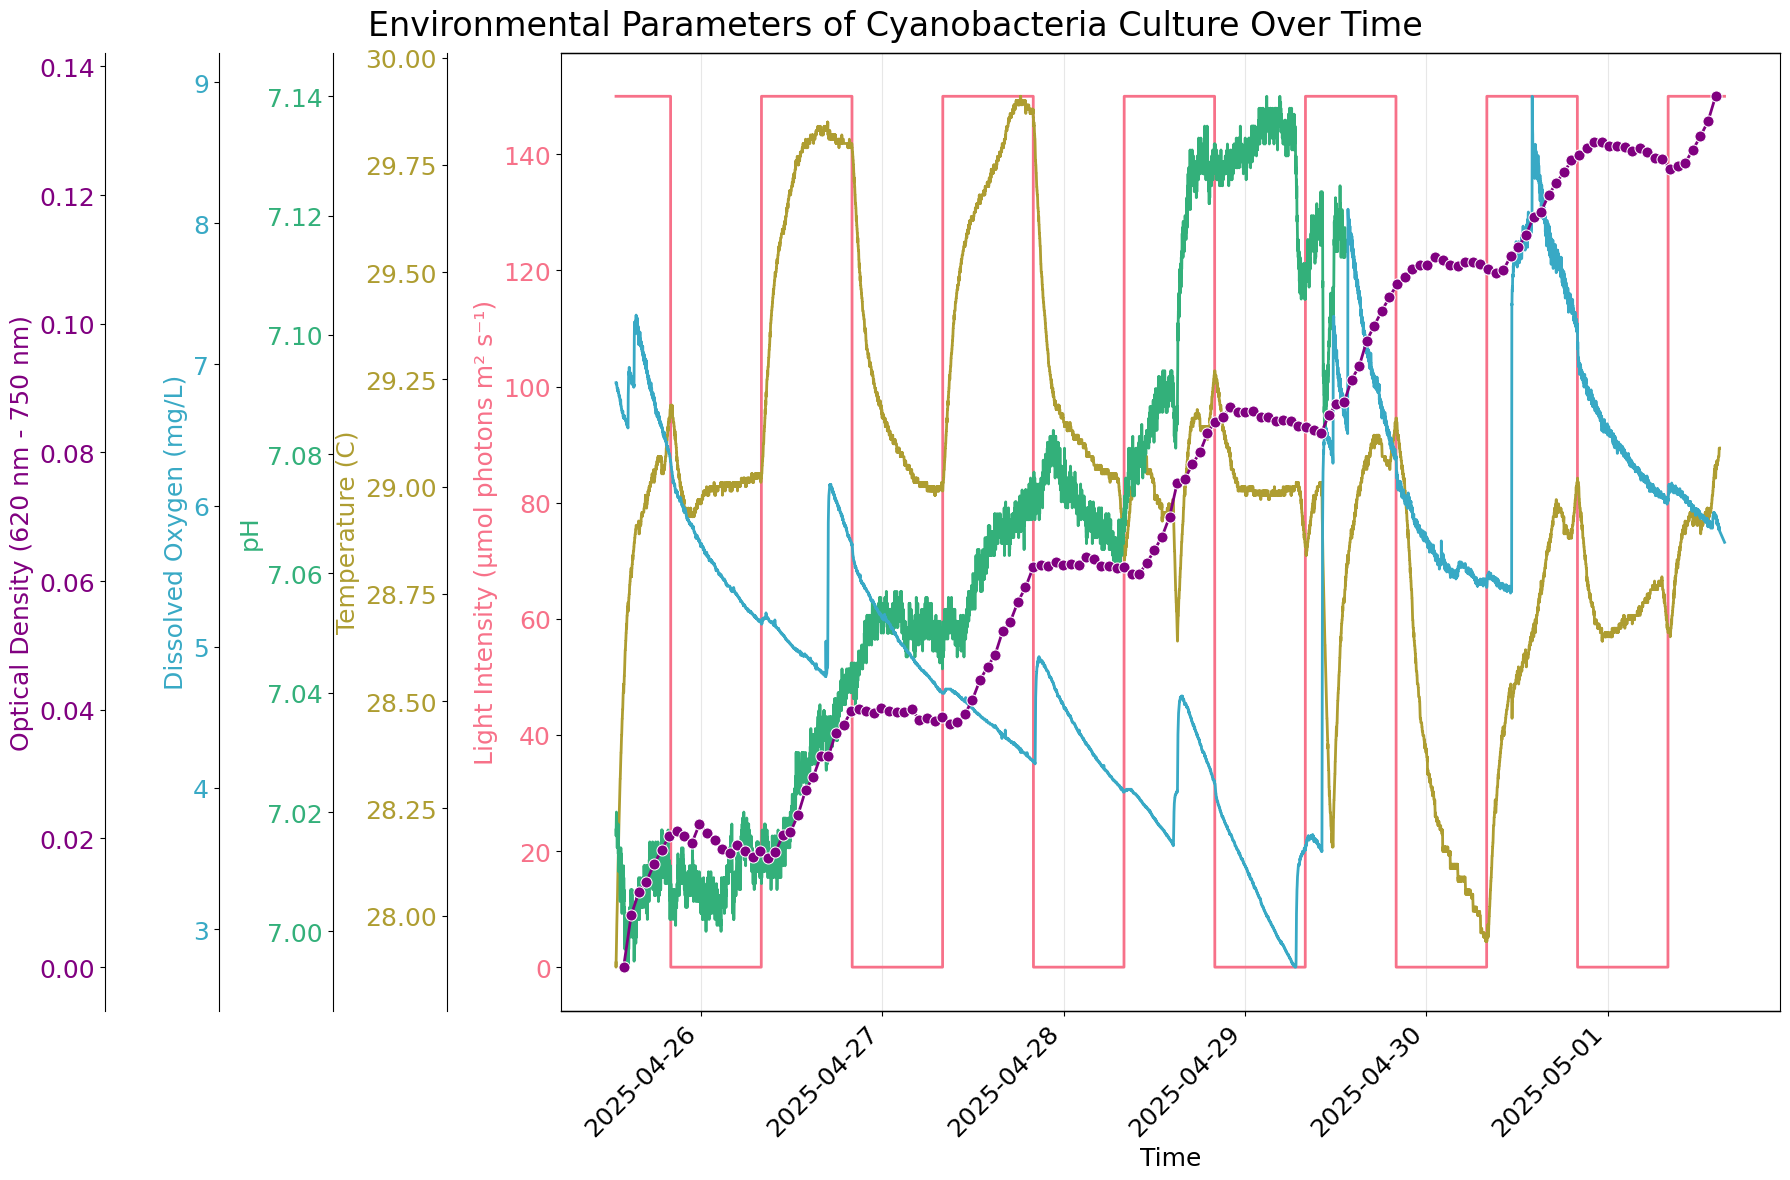

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the relevant data
lineplot_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen (mg/L)",
        "Optical Density (620 nm - 750 nm)",
    ]
].copy()

cols_to_downsample = [
    'Light Intensity (μmol photons m² s⁻¹)',
    "Temperature (C)",
    "pH",
    "Dissolved Oxygen (mg/L)",
]

for col in cols_to_downsample:
    if col in lineplot_data.columns:
        original_values = lineplot_data[col].copy()
        downsampled_series = pd.Series(np.nan, index=lineplot_data.index, dtype=original_values.dtype)
        downsampled_series.iloc[::50] = original_values.iloc[::50]
        lineplot_data[col] = downsampled_series
    else:
        print(f"Warning: Column '{col}' not found in lineplot_data for downsampling.")

lineplot_data = lineplot_data.dropna(how="all")

# Convert unixtime to datetime
lineplot_data['datetime'] = pd.to_datetime(lineplot_data['unixtime'], unit='s')
lineplot_data = lineplot_data.set_index('datetime')
lineplot_data = lineplot_data.drop(columns=['unixtime'])

# Create a color palette
columns_to_plot = lineplot_data.columns
if not columns_to_plot.empty:
    palette = sns.color_palette("husl", len(columns_to_plot))
else:
    print("Warning: No columns to plot after processing.")
    # Avoid script error if lineplot_data is empty
    columns_to_plot = pd.Index([]) 
    palette = []

fig, ax1 = plt.subplots(figsize=(18, 12))

axes = [ax1]
lines = [] # Initialize empty list for legend lines

# Plot the first variable (if any columns to plot)
if len(columns_to_plot) > 0:
    color = palette[0]
    ax1.set_xlabel('Time', fontsize=18)
    ax1.set_ylabel(columns_to_plot[0], color=color, fontsize=18)  # Increased label font size to 18
    # Plot data and get the Line2D object
    line_obj_ax1 = sns.lineplot(data=lineplot_data[columns_to_plot[0]], ax=ax1, color=color, linewidth=2, label=columns_to_plot[0], legend=False)
    # sns.lineplot returns the AxesSubplot, get the line from its .lines attribute
    if line_obj_ax1.lines:
        lines.append(line_obj_ax1.lines[0])
    
    ax1.tick_params(axis='y', labelcolor=color, labelsize=18)  # Increased tick label size to 18
    ax1.tick_params(axis='x', labelsize=18)  # Increased tick label size to 18 for x-axis
    ax1.grid(True, alpha=0.3, axis='x') # Grid only for the primary x-axis
    # ax1 is already on the left by default
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.tick_left()

# Plot subsequent variables on new y-axes, all on the left
if len(columns_to_plot) > 1:
    for i, column in enumerate(columns_to_plot[1:]): # i = 0 for 2nd var, 1 for 3rd var
        ax_new = ax1.twinx()
        axes.append(ax_new)
        color = palette[i+1]

        # --- MODIFICATIONS TO MOVE AXIS TO THE LEFT ---
        # 1. Make the default right spine invisible
        ax_new.spines["right"].set_visible(False)
        
        # 2. Make the left spine visible
        ax_new.spines["left"].set_visible(True)
        
        # 3. Position the new left y-axis spine to avoid overlap
        offset = (i + 1) * 82 
        ax_new.spines["left"].set_position(("outward", offset))
        
        # 4. Ensure ticks and label are on the left for this new axis
        ax_new.yaxis.tick_left() 
        ax_new.yaxis.set_label_position('left') # This was already in your original code for ax_new

        if column == "Optical Density (620 nm - 750 nm)":
            linewidth = 10  # thicker line
            linestyle = '-'  # solid line (optional)
            color = 'purple'  # override to a strong purple (or any color you want)
            label_fontsize = 22  # bigger y-label font
            tick_labelsize = 20  # bigger ticks font
            marker = 'o'              # Circle markers
            markersize = 8            # Bigger marker size
            label_fontsize = 22
            tick_labelsize = 20

        else:
            linewidth = 2
            linestyle = '-'
            label_fontsize = 18
            tick_labelsize = 18
            marker = None             # No markers for other lines
            markersize = 0


        # --- END MODIFICATIONS ---

        # Plot the data on the new axis
        line_obj_new = sns.lineplot(data=lineplot_data[column], ax=ax_new, color=color, linewidth=2, label=column,         marker=marker,      markersize=markersize, legend=False)
        if line_obj_new.lines:
            lines.append(line_obj_new.lines[0]) # Append the Line2D object

        ax_new.set_ylabel(column, color=color, fontsize=18)  # Increased y-label font size to 18
        ax_new.tick_params(axis='y', labelcolor=color, labelsize=18) # Apply color and font size to left tick labels

        ax_new.grid(False) # Turn off grid for these additional y-axes to reduce clutter

# Rotate the x-tick labels explicitly
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=18)

# Add an overall title using fig.suptitle()
fig.suptitle('Environmental Parameters of Cyanobacteria Culture Over Time', fontsize=24)

# Adjust the layout to make space for all labels
plt.tight_layout()

plt.show()


# Fun little exercise to try and look thru only the columns that have complete data for correlation matrix

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the columns we're interested in
correlation_data = df_combined[
    [
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen (mg/L)",
        "Optical Density (620 nm - 750 nm)",
    ]
]

# Drop rows with any missing values
complete_data = correlation_data.dropna(how="any")
complete_data


,Light Intensity (μmol photons m² s⁻¹),Temperature (C),pH,Dissolved Oxygen (mg/L),Optical Density (620 nm - 750 nm)
3802,150,28.53,7.006,6.63,-0.000000
3803,150,28.53,7.006,6.63,-0.000000
7564,150,28.81,7.005,6.91,0.008069
11312,150,28.91,7.006,7.14,0.011618
15059,150,28.98,7.007,7.00,0.013247
...,...,...,...,...,...
345992,150,28.97,7.114,3.65,0.083456
349744,150,29.00,7.120,3.57,0.083045
353494,150,28.32,7.100,6.46,0.085793
357242,150,28.43,7.116,7.04,0.087565


Original shape: (544507, 5), After dropping NAs: (101, 5)


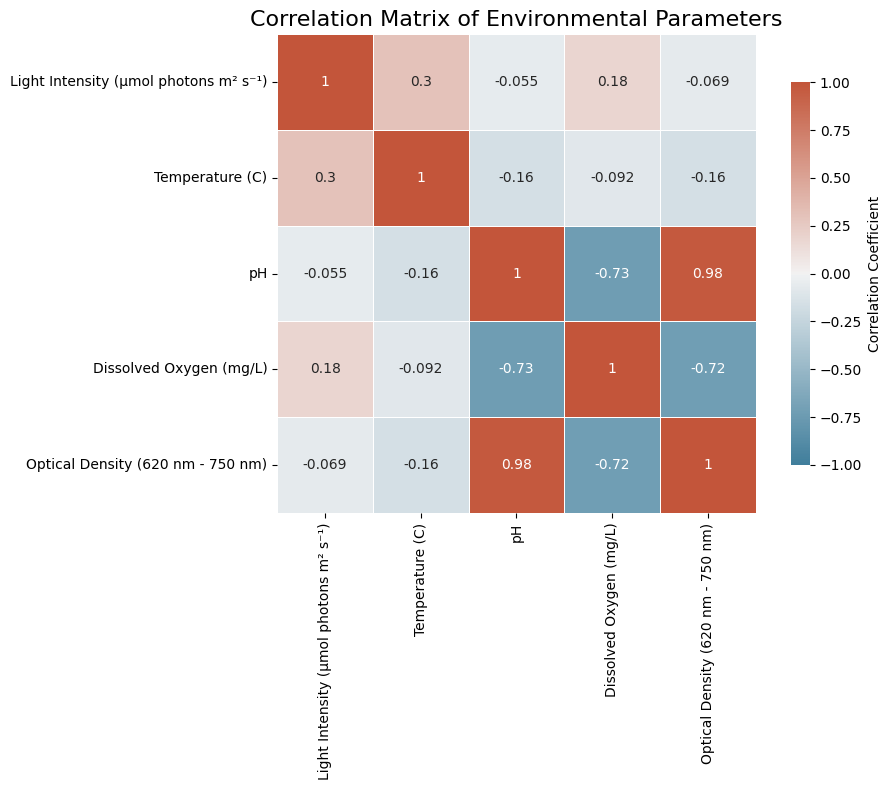


Correlation Matrix:
                                       Light Intensity (μmol photons m² s⁻¹)  \
Light Intensity (μmol photons m² s⁻¹)                                   1.00   
Temperature (C)                                                         0.30   
pH                                                                     -0.05   
Dissolved Oxygen (mg/L)                                                 0.18   
Optical Density (620 nm - 750 nm)                                      -0.07   

                                       Temperature (C)    pH  \
Light Intensity (μmol photons m² s⁻¹)             0.30 -0.05   
Temperature (C)                                   1.00 -0.16   
pH                                               -0.16  1.00   
Dissolved Oxygen (mg/L)                          -0.09 -0.73   
Optical Density (620 nm - 750 nm)                -0.16  0.98   

                                       Dissolved Oxygen (mg/L)  \
Light Intensity (μmol photons m² s⁻¹)          

<Figure size 1200x1000 with 0 Axes>

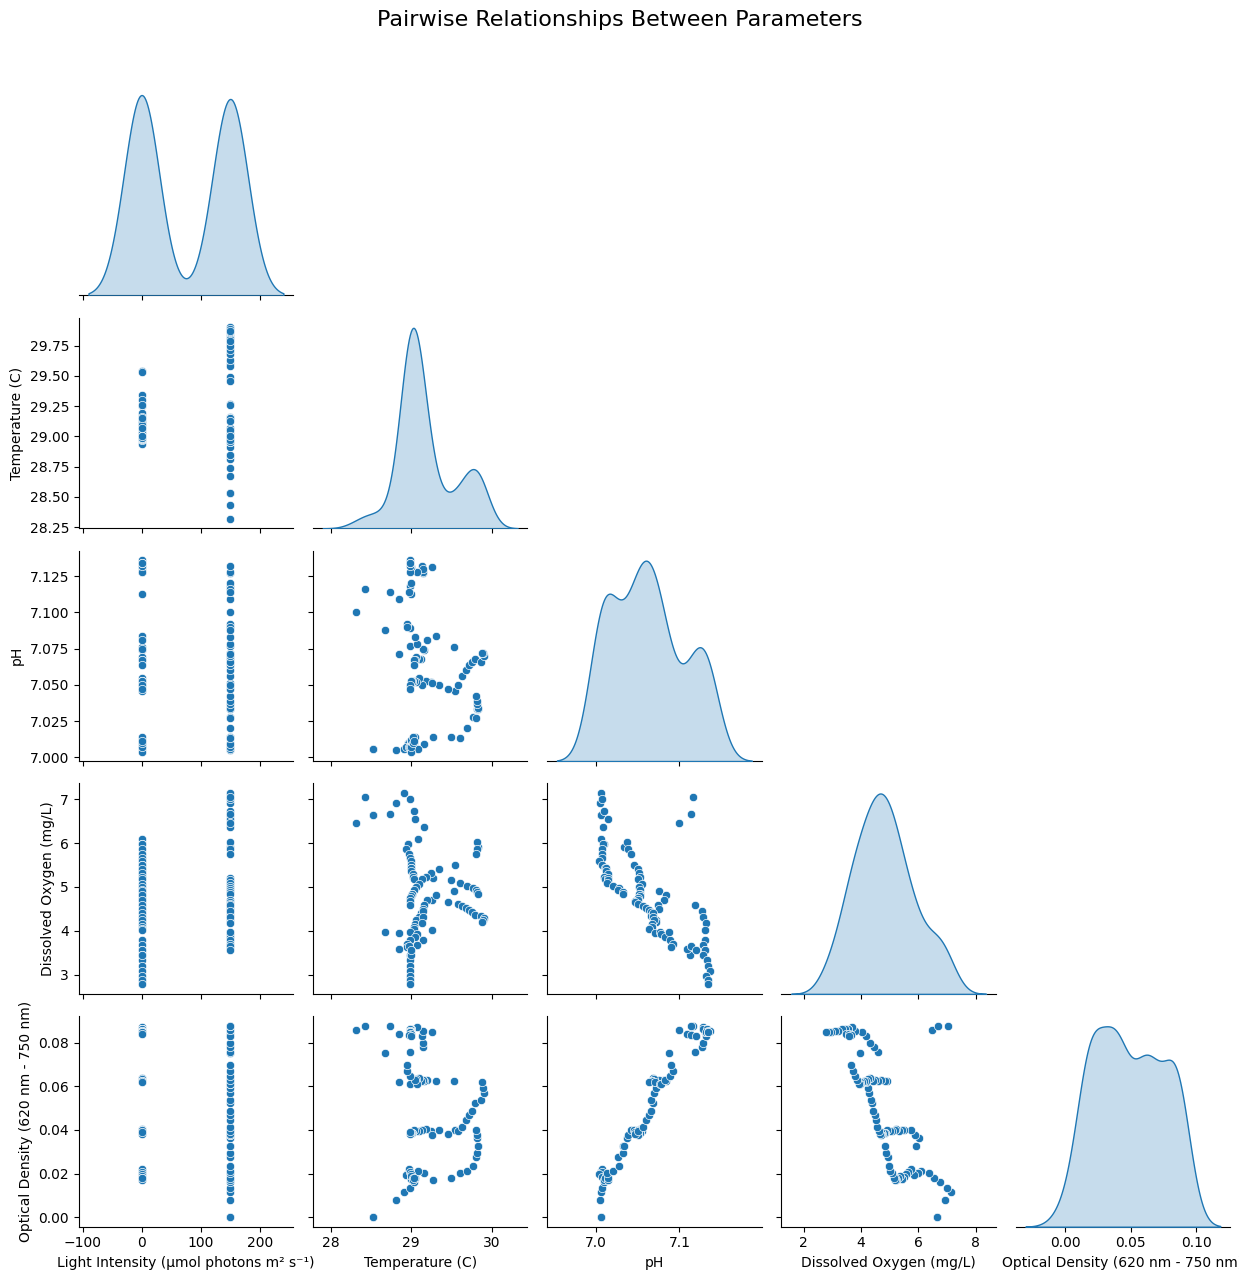

In [106]:
print(f"Original shape: {correlation_data.shape}, After dropping NAs: {complete_data.shape}")

# Calculate the correlation matrix
corr_matrix = complete_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with formatting
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Use a diverging colormap

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values
    cmap=cmap,   # Use our defined colormap
    vmax=1.0,    # Maximum correlation value
    vmin=-1.0,   # Minimum correlation value
    center=0,    # Center the colormap at zero
    square=True, # Make the cells square
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
)

plt.title('Correlation Matrix of Environmental Parameters', fontsize=16)
plt.tight_layout()
plt.show()

# Let's also look at the actual correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Additional analysis: descriptive statistics of complete data
print("\nDescriptive Statistics:")
print(complete_data.describe())

# You could also do a pairplot to see both distributions and correlations
plt.figure(figsize=(12, 10))
sns.pairplot(complete_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()